In [1]:
%pip install optproblems
%pip install numpy
%pip install matplotlib

import copy
import numpy as np
import random
import optproblems.cec2005 as test_funcs
from optproblems import *
import matplotlib.pyplot as plt


random.seed(100)
np.random.seed(100)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
def shifted_rastrigin(input):
    func = test_funcs.F9(len(input))
    sol = Individual(input)
    func.evaluate(sol)
    return sol.objective_values

In [3]:
def sphere(input):
    func = test_funcs.F1(len(input))
    sol = Individual(input)
    func.evaluate(sol)
    return sol.objective_values

In [4]:
#Expanded extended Griewank’s plus Rosenbrock’s function (F8F2)

def shifted_f13(input):
    func = test_funcs.F13(len(input))
    sol = Individual(input)
    func.evaluate(sol)
    return sol.objective_values

In [5]:
def make_line_graph(value_list, line_label, xlimits, ylimits):
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    ax.plot(value_list, label= line_label, color = 'red')
    plt.legend(loc='best')
    plt.xlim(xlimits)
    plt.ylim(ylimits)
    plt.show(block=True)

In [6]:
class GA():
    
    def __init__(self, population_size, dimension, elites, crossover_rate,\
                 mutation_rate, min_value, max_value, benchmark):
        
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elites = elites
        self.population_size = population_size
        self.dimension = dimension
        self.min_value = min_value
        self.max_value = max_value
        self.population = []
        self.fitness = []
        self.benchmark = benchmark
        self.best_fitness_list = []
        
        ''' Generate Initial Population and calculate fitness '''
        self.generate_random_population()
        
        
    def generate_random_population(self):
        for i in range(self.population_size):
            self.population.append(np.random.uniform(low=self.min_value,\
                                                     high=self.max_value, \
                                                     size=self.dimension))
        self.fitness = [self.benchmark(self.population[i]) \
                        for i in range(self.population_size)] 

    
    def tournament_selection(self, num_candidates):
        candidates = []
        best_candidate_index = None
        # Getting random indexes to get candidates for selection
        candidates_index_list = random.sample(range(0, self.population_size)\
                                              , num_candidates)
    
        for i in candidates_index_list:
            if best_candidate_index is None or \
            self.fitness[i] < self.fitness[best_candidate_index]:
                best_candidate_index = i
        return self.population[best_candidate_index]
    
    
    def sort_genotypes(self):
        return np.argsort(self.fitness)
    
    
    def one_point_crossover(self, parent1, parent2):
        
        if (random.random() < self.crossover_rate):
            ''' Choosing crossover point and making sure it is not the end '''
            cross_point = random.randint(1, len(parent1)-2)
            child1 = np.concatenate((parent1[:cross_point], parent2[cross_point:]))
            child2 = np.concatenate((parent2[:cross_point], parent1[cross_point:]))
            return child1, child2
        else:
            return parent1, parent2
    
    
    def mutation(self, genotype, mutation_type, generation_num):
        # make sure to return ndarray
        mutated_genotype = []
 
        for gene in range(len(genotype)):
            if random.random() < self.mutation_rate:
                
                ''' checking mutation type to use Uniform or Gaussian Distribution '''
                if mutation_type.lower() == "gaussian":
                    
                    '''
                    Decreasing standard deviation with iteration to limit movement as
                    the algo reaches close to optimum solution
                    '''
                    init_std = 0.8
                    final_std = 0.1
                    temp_std = (init_std - final_std)* \
                    ((self.num_iterations - generation_num)/self.num_iterations)
                    
                    random_value = np.random.normal(genotype[gene], temp_std*\
                                    (self.max_value - self.min_value))
                
                elif mutation_type.lower() == "uniform":
                    random_value = np.random.uniform(self.min_value, self.max_value)
                
                temp_val = genotype[gene] + random_value
                
                ''' Clipping values '''
                if temp_val < self.min_value: 
                    temp_val = self.min_value
                    
                elif temp_val > self.max_value:
                    temp_val = self.max_value
                mutated_genotype.append(temp_val)
            else:
                mutated_genotype.append(genotype[gene])
        return np.asarray(mutated_genotype)
    
    
    def replacement(self, sort_fitness_index, mutation_type, elites, generation_num):
        ''' Method to create new generation from previous generations
            Calls method for tournament selection and mutation
        '''
        temp_pop = [] 
            
        for i in range(round(len(sort_fitness_index)/2) + elites):
            
            if i in range(elites):
                temp_pop.append(self.population[sort_fitness_index[i]])
                continue
                
            parent1 = self.tournament_selection(10)
            parent2 = self.tournament_selection(10)
            child1, child2 = self.one_point_crossover(parent1, parent2)
            
            ''' Managing condition when odd number of population is there '''
            
            if len(temp_pop) != self.population_size -1 \
            and len(temp_pop) != self.population_size:
                temp_pop.append(self.mutation(child1, mutation_type, generation_num))
                temp_pop.append(self.mutation(child2, mutation_type, generation_num))
            elif len(temp_pop) != self.population_size:
                temp_pop.append(self.mutation(child1, mutation_type, generation_num))
        return copy.copy(temp_pop)
    
    
    def run(self, num_iterations, mutation_type):
        
        best_genotype = None
        best_fitness = None
        self.num_iterations = num_iterations
        
        for i in range(num_iterations):
            self.fitness = [self.benchmark(self.population[j])\
                            for j in range(self.population_size)]
            sort_fitness_index = self.sort_genotypes()
            temp_best_fit = self.fitness[sort_fitness_index[0]]
            self.best_fitness_list.append(temp_best_fit)
            if i % 100 == 0:
                print ("Iteration = {}  |  Best Fitness = {}".format(i, temp_best_fit))
                
                
            ''' Calculating normalized count to pass to mutation for linear decreasing
                standard deviation for Gaussian distribution 
            '''
            gen_count_normalized = (num_iterations - i)/num_iterations
            self.population = self.replacement(sort_fitness_index, mutation_type, \
                                               self.elites, gen_count_normalized)
            
        self.fitness = [self.benchmark(self.population[i]) \
                        for i in range(self.population_size)]
        sort_fitness_index = self.sort_genotypes()
        print ("Final | Best Fitness = {}".format(self.fitness[sort_fitness_index[0]]))
        self.best_fitness_list.append(self.fitness[sort_fitness_index[0]])
        return self.best_fitness_list

## Sphere 

In [7]:
population = 200
dimensions = 15
elites_num = 15
crossover = 0.9
mutation = 0.1
min_value_x = -100
max_value_x = 100
iterations = 500

In [8]:
out_list = np.zeros(iterations  +1)
out_best_list = []
for i in range(10):
    print ("RUN {}".format(i+1))
    sphere_ga = GA(population_size=population, dimension=dimensions, \
                   elites=elites_num,\
                   crossover_rate=crossover, \
                   mutation_rate=mutation, min_value=min_value_x, \
                   max_value=max_value_x,\
                   benchmark = sphere)
    sphere_out_list = sphere_ga.run(iterations, "gaussian")
    out_list = out_list + np.asarray(sphere_out_list)
    out_best_list.append(sphere_out_list[-1])

RUN 1
Iteration = 0  |  Best Fitness = 16118.913999796234
Iteration = 100  |  Best Fitness = -438.7464897819019
Iteration = 200  |  Best Fitness = -447.35981026100364
Iteration = 300  |  Best Fitness = -449.7232397174835
Iteration = 400  |  Best Fitness = -449.7740637697043
Final | Best Fitness = -449.93361141570625
RUN 2
Iteration = 0  |  Best Fitness = 34590.26090078525
Iteration = 100  |  Best Fitness = -432.9830969025493
Iteration = 200  |  Best Fitness = -447.8288138212633
Iteration = 300  |  Best Fitness = -449.39912699771077
Iteration = 400  |  Best Fitness = -449.5581327666689
Final | Best Fitness = -449.726373175265
RUN 3
Iteration = 0  |  Best Fitness = 27893.006514835062
Iteration = 100  |  Best Fitness = -426.994390742216
Iteration = 200  |  Best Fitness = -447.53457375664516
Iteration = 300  |  Best Fitness = -449.72173029778406
Iteration = 400  |  Best Fitness = -449.8656706770408
Final | Best Fitness = -449.8923995529288
RUN 4
Iteration = 0  |  Best Fitness = 25530.82469

In [9]:
out_list = out_list/10.0
out_best_list = np.asarray(out_best_list)
out_best_std = np.std(out_best_list)
out_best_mean = np.mean(out_best_list)
error = (-450 - out_best_list)
print ("BEST FITNESS = {}".format(out_best_list))
print ("Error = {}".format(error))

BEST FITNESS = [-449.93361142 -449.72637318 -449.89239955 -449.78035488 -449.56322511
 -449.81574097 -449.52662853 -449.39097793 -449.80868852 -449.65282509]
Error = [-0.06638858 -0.27362682 -0.10760045 -0.21964512 -0.43677489 -0.18425903
 -0.47337147 -0.60902207 -0.19131148 -0.34717491]


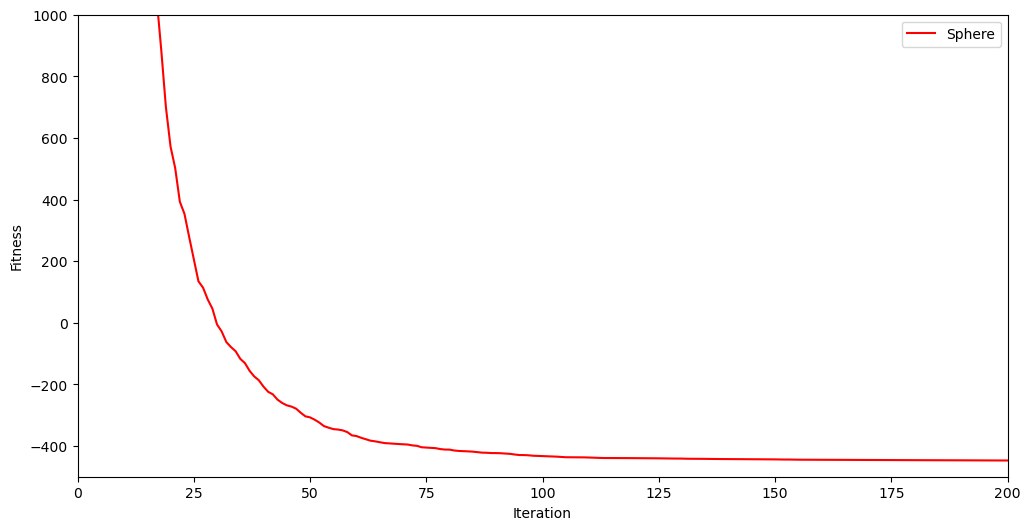

In [10]:
make_line_graph(out_list, "Sphere", [0, 200], [-500,1000])

# Expanded extended Griewank’s plus Rosenbrock’s function (F8F2)

In [11]:
population = 400
dimensions = 15
elites_num = 15
crossover = 0.9
mutation = 0.09
min_value_x = -3
max_value_x = 1
iterations = 1000

In [12]:
out_list_f13 = np.zeros(iterations +1)
out_best_list_f13 = []
for i in range(10):
    print ("RUN {}".format(i+1))
    f13 = GA(population_size=population, dimension=dimensions, elites=elites_num,\
             crossover_rate=crossover, \
             mutation_rate=mutation, min_value=min_value_x, max_value=max_value_x,\
             benchmark = shifted_f13)
    
    f13_out_list = f13.run(iterations, "gaussian")
    
    out_list_f13 = out_list_f13 + np.asarray(f13_out_list)
    out_best_list_f13.append(f13_out_list[-1])

RUN 1
Iteration = 0  |  Best Fitness = -84.07764820598007
Iteration = 100  |  Best Fitness = -129.28019556283041
Iteration = 200  |  Best Fitness = -129.4628600303467
Iteration = 300  |  Best Fitness = -129.52767811696037
Iteration = 400  |  Best Fitness = -129.54951594931248
Iteration = 500  |  Best Fitness = -129.5623488783998
Iteration = 600  |  Best Fitness = -129.56733323886024
Iteration = 700  |  Best Fitness = -129.57788294910247
Iteration = 800  |  Best Fitness = -129.57824131379815
Iteration = 900  |  Best Fitness = -129.58385541886864
Final | Best Fitness = -129.5926549907431
RUN 2
Iteration = 0  |  Best Fitness = -5.205389278020931
Iteration = 100  |  Best Fitness = -128.8806789205041
Iteration = 200  |  Best Fitness = -128.98508923813483
Iteration = 300  |  Best Fitness = -129.0321298343555
Iteration = 400  |  Best Fitness = -129.04111402699488
Iteration = 500  |  Best Fitness = -129.04464639312758
Iteration = 600  |  Best Fitness = -129.3091183513488
Iteration = 700  |  Be

In [13]:
out_list_f13 = out_list_f13/10.0
out_best_list_f13 = np.asarray(out_best_list_f13)
out_best_std_f13 = np.std(out_best_list_f13)
out_best_mean_f13 = np.mean(out_best_list_f13)
error = (-130 - out_best_list_f13)
print ("BEST FITNESS = {}".format(out_best_list_f13))
print ("Error = {}".format(error))

BEST FITNESS = [-129.59265499 -129.38073356 -129.2130329  -129.05012573 -129.58234339
 -129.41441751 -129.61281485 -129.21540253 -129.48123416 -129.52677321]
Error = [-0.40734501 -0.61926644 -0.7869671  -0.94987427 -0.41765661 -0.58558249
 -0.38718515 -0.78459747 -0.51876584 -0.47322679]


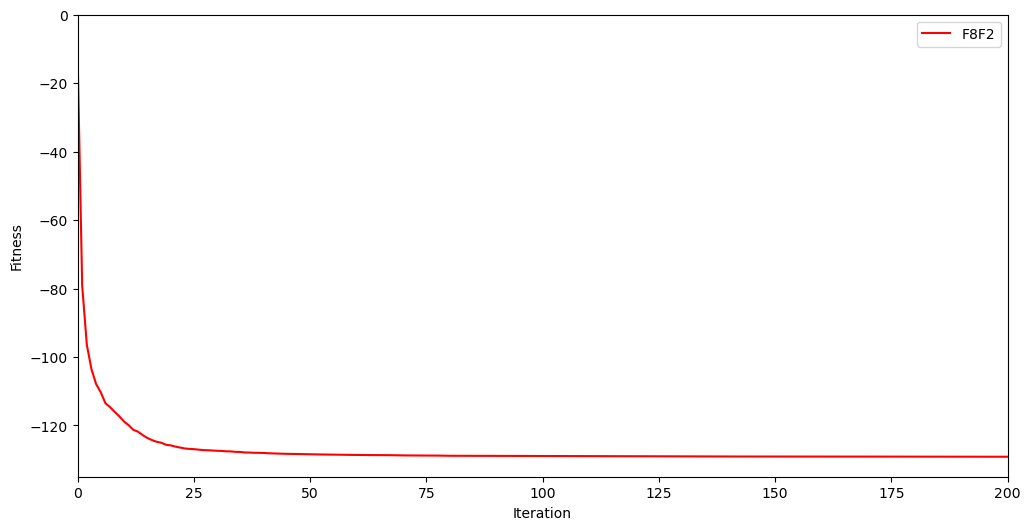

In [14]:
make_line_graph(out_list_f13, "F8F2" , [0,200], [-135, 0])

## Shifted Rastrigin

In [15]:
population = 1000
dimensions = 15
elites_num = 50
crossover = 0.8
mutation = 0.15
min_value_x = -5
max_value_x = 5
iterations = 500

In [16]:
out_list_rast = np.zeros(iterations +1)
out_best_list_rast = []

for i in range(10):
    print ("RUN {}".format(i+1))
    rast_ga = GA(population_size=population, dimension=dimensions, \
                 elites=elites_num, crossover_rate=crossover, \
                 mutation_rate=mutation, min_value=min_value_x, \
                 max_value=max_value_x, benchmark = shifted_rastrigin)
    rast_out_list = rast_ga.run(iterations, "gaussian")
    
    out_list_rast = out_list_rast + np.asarray(rast_out_list)
    out_best_list_rast.append(rast_out_list[-1])

RUN 1
Iteration = 0  |  Best Fitness = -163.54722950108174
Iteration = 100  |  Best Fitness = -328.05004366488515
Iteration = 200  |  Best Fitness = -329.64383161896745
Iteration = 300  |  Best Fitness = -329.717681336081
Iteration = 400  |  Best Fitness = -329.9227135144082
Final | Best Fitness = -329.949659124704
RUN 2
Iteration = 0  |  Best Fitness = -145.38470652778946
Iteration = 100  |  Best Fitness = -327.8257530123392
Iteration = 200  |  Best Fitness = -329.6211830922022
Iteration = 300  |  Best Fitness = -329.88487938401994
Iteration = 400  |  Best Fitness = -329.92891437340194
Final | Best Fitness = -329.94826512015084
RUN 3
Iteration = 0  |  Best Fitness = -132.08648963998104
Iteration = 100  |  Best Fitness = -328.7156902412902
Iteration = 200  |  Best Fitness = -329.566979295335
Iteration = 300  |  Best Fitness = -329.7856702342953
Iteration = 400  |  Best Fitness = -329.91315748402843
Final | Best Fitness = -329.9558070521867
RUN 4
Iteration = 0  |  Best Fitness = -149.96

In [17]:
out_list_rast = out_list_rast/10.0
out_best_list_rast = np.asarray(out_best_list_rast)
out_best_std = np.std(out_best_list_rast)
out_best_mean = np.mean(out_best_list_rast)
error = (-330 - out_best_list_rast)
print ("BEST FITNESS = {}".format(out_best_list_rast))
print ("Error = {}".format(error))

BEST FITNESS = [-329.94965912 -329.94826512 -329.95580705 -329.94469194 -329.97635789
 -329.94524101 -329.95048413 -329.95013963 -329.98744468 -329.96909544]
Error = [-0.05034088 -0.05173488 -0.04419295 -0.05530806 -0.02364211 -0.05475899
 -0.04951587 -0.04986037 -0.01255532 -0.03090456]


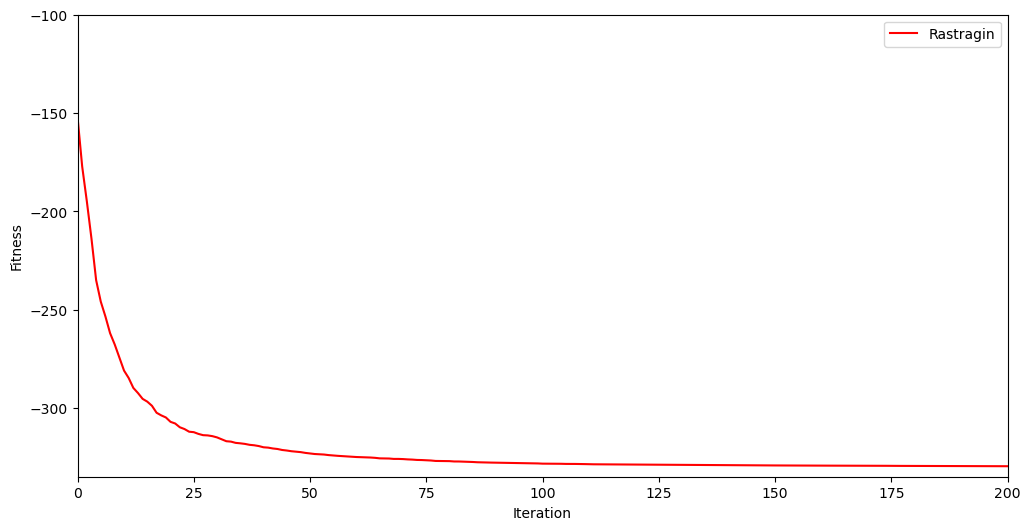

In [18]:
make_line_graph(out_list_rast, "Rastragin", [0,200], [-335, -100])